In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""A deep MNIST classifier using convolutional layers.

See extensive documentation at
https://www.tensorflow.org/get_started/mnist/pros
"""
# Disable linter warnings to maintain consistency with tutorial.
# pylint: disable=invalid-name
# pylint: disable=g-bad-import-order

'A deep MNIST classifier using convolutional layers.\n\nSee extensive documentation at\nhttps://www.tensorflow.org/get_started/mnist/pros\n'

In [2]:
import os
# Using first CUDA device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Disable GPU access
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: decodestring() is a deprecated alias, use decodebytes()
  import sys


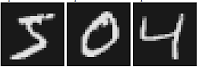

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import Image
import base64
Image(data=base64.decodestring("iVBORw0KGgoAAAANSUhEUgAAAMYAAABFCAYAAAARv5krAAAYl0lEQVR4Ae3dV4wc1bYG4D3YYJucc8455yCSSIYrBAi4EjriAZHECyAk3rAID1gCIXGRgIvASIQr8UTmgDA5imByPpicTcYGY+yrbx+tOUWpu2e6u7qnZ7qXVFPVVbv2Xutfce+q7hlasmTJktSAXrnn8vR/3/xXmnnadg1aTfxL3/7rwfSPmT+kf/7vf098YRtK+FnaZaf/SS++OjNNathufF9caiT2v/xxqbTGki/SXyM1nODXv/r8+7Tb+r+lnxZNcEFHEG/e3LnpoINXSh/PWzxCy/F9eWjOnDlLrr/++jR16tQakgylqdOWTZOGFqX5C/5IjXNLjdt7/NTvv/+eTjnllLT//vunr776Kl100UVpueWWq8n10lOmpSmTU5o/f0Fa3DDH1ry9p0/++eefaZ999slYYPS0005LK664Yk2eJ02ekqZNnZx+XzA/LfprYgGxePHitOqqq6YZM2akyfPmzUvXXXddHceoic2EOckxDj300CzPggUL0g033NC3OKy00krDer3pppv6FgcBIjvGUkv9u5paZZVVhoHpl4Mvv/wyhfxDQ0NZ7H7EQbacPHny39Tejzj88ccfacqUKRmHEecYf0Nr8GGAQJ8gMHCMPlH0QMzmEBg4RnN4DVr3CQIDx+gTRQ/EbA6BgWM0h9egdZ8g8PeliD4RutfF/Ouvfz9OtZy8aNGiNH/+/GGWl1122XzseYuVNKtqsaI23Ghw0DYCA8doG8JqO+AUG2+8cVq4cGHaY4890vLLL5/WXXfdfI6jvPDCC3lJ8amnnkoezP3000/pl19+GThHtWpIPekYomTxFS7HnkqKjMsss0yGgFE4r62tSBFVJ02aNPyconi9V4/JwzHwT9ZNNtkkeZ6w5ZZbph133DH99ttv6ccff8zXX3nllcRRnHNfv2cNGMQWGRaOrWbUrjsGBRLAA6U4Lhoqw9h2223ztRBq6aWXzsbgvueffz4Lu9NOO2UnYTgrr7xy7tO9nOH111/Pbb744ov0ww8/jAvngAdFMvQDDjggG/0GG2yQX1GZNm1aziCCwzrrrJPl3muvvXKwePnll9M333wzHDCKWPbLMbuAkfISjnvvvXcW/emnn85lqCBqa4a65hiYR/Gk2RNGRlwm3n7ggQfmdrKD9sqJtdZaKxvCnDlz8n3Tp09PXmPYeuutc0SVNQjvnmuvvTa3efzxx9N33303PGZ5rF75DBvvqq233nrp22+/TWeddVbyikpgxCE4vQDhlQUBRfDw2esbs2fPTquvvnqviNN1PuIdJ4GErVx44YUZowsuuCB9+umn6eeff84BspmsWqljhPFDxjGGYx/lDkN33udajCoVlAjRzl4U8LjefRwnPjsXG8OJqKBd8NB1LTU5IHyCd7LJGOYXNoGjFqaGIKtrERDIDKtukfGMH/zRZa1A101+YBF44KfMYzO8VOYYjDWiukiGqc022yyXOUqdzTffPJ/z1ialeqNVxA9gi0wzlOJ5juJlR8JeddVV+ZrIKTq4ZvJp/8EHH+SU+txzz+W2SqmxVFZRplrH5DTRXmGFFdKuu+6azjjjjOzosl5g6D54CQCI4mGjhNQO5occckh2LvLTA6fqJOEnyhU6kNlkZmUuvrtNcFx77bUzhsZWXgoSsm6t4Dsa/tp2DErCmA04HAI4FLjaaqtlBhmnSKiNY4rDtHZFB6jFMMH0RVDH+nCPYxtDCFJnKkniRbDitWjTK3sykQUuMLPn3DZGX8SFnCG/fVyz5zCCBtIHTLshdzif8fERn8cKXxjCNOwCTu3Qf6yqhV4AQokiP489//zzM0DxnQYKwqAtIkko1kQzFFxvaNcJ6u3Pe+65J/cRRvDee+9lA2BInIyRff/997nNO++8k7t0vl2A6vHWynmyiPJ43WKLLbIijz/++LTddtvlTCdzwIWSg9yjxBJ0GN/DDz+c7zv77LOzbEceeWSekwVGgsOsWbNyNo0+qt7DfPvtt8/dmtvIGnPnzk3PPPPMsJ6rHrNef/BBeJA90RprrJEDcNhctMkXR/mnbccwuCjNGTbaaKMc8TBZprITxOdgOvbuKxqGz6LSJ598kseJ9Gi1CYmSv/76a3YyJZWMZJ6Ceskp8EMusihFEAyUmVaa8G2rxTNHIrd733///eH7YeaLNe5xrEzlWNF/HqQDf0Tm+GIbvYdD43MsKAIo/JDgE0G5aFfN8NaWYxiUshikqGYTTUSt0TCkjXsYNqJQQso+rgGa0vX58ccf56hQTtk+48F92rmvlnE1A0on2uKP0Yrw+Nxzzz0zn+ZhjKwRXq6vueaa2TmUiRQfS7SyNeMks9IV9vrvJOl/q622yo4Mfw5Pvm6TMclLdit6shh+YAMnq1E29tEsteUYBgMSgxa5MOAzJZcVXQs4bUR8XxhCHIwzMALCBuCcx5q0tF3u133l8XrRMchFiRYNyMxBKM/5IjZlWVzjULKwACISytIWFsi56aab5mvOKyEikmdAO/iHY+BDCRUZuoPD1e1akECyLseA7d13352DhdKak8Cmlt3U7TSl9p58FwejYK8ncAwKpDTnGDcARbWiAUjHiNEHsITSPlagpEZChcfrZzwSOfBOiQwXLuR3PjAhtwAD08iAMCO/a+5xPTIm3ALjwERf0V+c69QeT7ZujVdLDhgKBrANXAMreMESRkU7rdVPrXNtZ4xIpSLH1VdfnR3j4IMPzkbw2Wefpa+//jovo5188slZsZjArAcvFP3YY4+lSy+9NEdTdTTy0I5xHHfccfm1CH2LtuORKEqmkwVlVU+sBY+IdJRmE0zeeOONnEXuu+++7AhnnnlmWn/99XMJ5brtzTffzHMJx/o555xzkgdb0U8rRtAKrnTYqtG1Ml6teyxInHDCCdlGYByBmG2Z97ChVvFo2zEwbHCRTbqP7EDxPjN2pUBEe86AXAcsg+f10TYMSTvnRM1ulQe1wG/nHEXZZEJZUIYQ5cgWMsEgMgqclFdkdh+MbFFyuddnWMLNfTYkcuuXHlBkpFYNI3dS+mMMfCHHsZWadfUjmQVn8iLywscG21apMscQwR555JEM3KuvvpoZ5LHOmzgjAvBwzFt2/Oijj3Lm4Ayin/MU/eGHH+b2N998c/5MGSaZ44nw7OEd5Rx77LE5+1EehYXxkpes5li2K6+8Mhv8Lrvsko381ltvzcEBfvHQKh5auk9GPvHEE3NJAx+/eKL/HXbYIQcbK3nwN067xAk4s5VHdbvsx0nxrYQeKxJMZAfBA7GlRx99NC9EtCN7JY4RoPBeAHIAyrB3jpHYwqu1d02d7HpZcfqINo5dL7eJMXtxTzk2sgWFM/gcsnCakI2cFOk+523O+Qw7WaeYHYpYRp9xn4BkbPdWSfgJXYYM+ne+2xRj2sdx8EDu8rm4Ntp9pY4RSmb0CIPOAVNGoLA47yU4S2xen37ppZdy9CkLE/3lm8bJHzJbbiavt2Q9p7AkK7oyXAZOLk7gs9c4PJC0AOE8DDyrgJkaWgYQkSPYuAdpWySfteU8HhqKouYq+io6ZfGeZo7xpbT1+jt+jGULfprpq922ePHMBibwjWVq523KVrzBsIzTaMeu1DFi0HI0YyyYtAekY5MltbRyihFJiROBKIYTwMCTWJNubwdQFCXFapK9z96mtbjgs3thFKWnUgjBzNZIya5FOyUcPG36q4LwRgZ6Ix8HtBk3tirGGU0feAkslHfk5PzBh2cXSkvtWqWOOEaRGcoSHdXDMoYn1tK8yaON0ahbCWgFS/vxSnjn5F4ItLeiFAGAzCKc7MDA1OlIjc4pLFKE7FEyxb5ZPNTbtuiv2fvrtddfOFsYXcwj8d8qv/XGq3femLvvvnvOvrIYPPEjG+PDseDbDnXcMXiyiGiyyACOPvrovN95552zV3/++ef5zVveznlEo6CICvG5l/d4JSvHP+qoo7JjKDs4PkVSGPm9HSz9W5rlPEoCQYHjVFXyRGnBOcKA28VOP/qTBWX6YnS2IKB8qYL/enyGHPbKziOOOCLj6sGeslGW8L6Y4ANr2MY99fpsdL7jjmFwkSTSr6gDVCk+tmDQedcJ5LgdwaLPbu7xjJRRNlErSsiQhVHJlOEQoh182o1wRTnharwYs3itnWP9Rd/RD5mLW5yveh/YRhYMjItyBh/wjPat8tEVx6B00RKo5513XpIl7rzzzuwEourMmTOz95uIcyBfTSXYiy++mCOrSFS1klsFrNZ9eGPoJtmeyRx00EE5cpGbIi21XnbZZbkMee2117KMHIKMIVcotVb/vXoOz6I0+URoMlVFcBFE7L1+IjNYIo6v/fo+D3tC+FCR+FHuwNUCgfOtUlccI5hnJMoIBhN1sBICqMoNNaLP3pkiFGciIIBC4HaEbRWk0dyHb3Mp/EY0I6+NsytvyKxsKhpQr8ozGpm1IZ8IbV+PyllGuyh1YBXXOQEcy6R8M5eAHzuxxX3GRvbaCKJ4aRfXrjkG5jEbk00Prxi8SZTJKmc5/PDDc5v99tsvC+hBjWtqStmD0F4Ma1foMvDtfqZMUc3/lYjMSFFW3NS7JtyyoKzSiTocHoFJHMc+MlK7Mta7n9NbATJerbEYvQWIWCVitIyaXrV3nsG7H2Y2GVcbxyj6NX+waKEPmOvbfShwtjhQDDz5Ygt/uuoY+OPtnICDEMBTWsAQUu0NBBsDEgFEWOADAiDaVRERWsCq5i34IRN+TbTJgn8KwzOFuR4KDUXW7Kyik53Ep8w/+RkxWeO5S1EM5wVABguXMGp69dk1x87D0ObdL32GHI5tsDQGHtwbm/Hw4TpnKvNY5Ge0x113DEwT3tIsIdSnDIfxcxJAevCHfE9cXcmotHXfAw88kIFUdgFjLMn4HuZRuh9FExmjRCCnZxRqcPxz8ioUVk9eRhJkPAYHV8ZVFRkjjFSfAtw222yTy2OZ0iv15fHcQ4dKaMcwsBdEEL26RzaIh5+yK7LSBGPno8yOZX+vzRhfXzZ8cRrtyzzkzpr803XHwB8wTJYIRol+VY8zqMMBbP0f+cExE1qTdbU7x3jwwQdzVBYdesExKNiEWx2MfwoOAyCbJ9uRHZvUTcPmsENhGNE4HBKOHKNqZzQu3KNfX9H1nRABQZlbNkpt4SNo4DWIIesDj9qYnwki2giWqol3330348kZLPm7xvi1Pffcc7MzhA3gy/0oeIuxWtmPiWNgNCIFYwcCAa2FA1ikJZz1aeUVsBmge9TyoqGoIqKUFdEKCFXcU0/pHJizVMUnXBiBh6IicdTTzsEOnuZkDE/2rcJI4KMf/TF+0TucwDhkZ+DGL4/nGkPGV/AIC+2RvfP6ZPTI4gu5XNM/Um7RPzuIFyn1zW7wpQ9UHj+fbOHPmDlGCOGBGIeQQfwuq0jnISBQfOHft7JEHN94Q5xF6XLFFVfkyKIEGyuiGAo3r6BIx0imcM6k+6GHHspOEQbcDq+UTl4BwRu7PstUiPEJFsa9/PLL83nXg6d2xnUvoxS5L7744uGyh/wyRpRF9YwSHsHjE088kWWADQeRFThZkTgBstensZG5h4m56oEdcAp9CwTOVUlj6hgECcGBpA6XDazeiLKhVABQAhKB3cNxbEAL4KoEppm+gjf3OMafDf+UW7zeTL/ltqIiAxBMOIIxnLOHgbFsMGQ4InhE0nJfrXw2hnIRD3SFBKmYWDfqE49woFvOzZno3NxM0HDciMjBDsjEBgLTsJHYN+qjmWtj7hjBLKFFQgL7qRz14jHHHJPBcC2M3wRPVDT5ohzZRv0Z16O/sdozAKmdopUH5kftTrzJpl+lk29CcgpLw3BgpMbwwqF/S80pGJ6xO0WM+8Ybbxw2TuOEoTYakwyovB/JKdzDMVQOHvCRzXju890fL11aGhcMqqIxdwwCRkYQDZAaE7lWBhyosQEmQM439MgffDHm0Si8EcuBC0ezcQSZVKYktzFEW+3sfQ4natRvu9eMTS9F7IvHo+m/2fb6LNuCc0WsW+mzHq9j6hgE9YCHp5tkez2EAVjlMOmyUlU2Lis8ygVR0rykyoltPZCaOY9fr32Qp50X6xi7pWCGbsHBvwLgGIcddljGxvcsjOU1GseyiKjJQWydpiqNsBlei85BfhNxeJunVCl31x0jBOMAjJ9jRC3OEERDS7QMI0qQohIYgLSq7FJuMZbi9WZA7kRbvFAWx5Dyy449mjEDG/dyDPW4VSiy2iNvBcCSUdxyyy35OYHrqJUx843j8I/qQpA074BVVdR1x+AIHCIiIGewsqIuds41tSSlOxeOFHuOQ/E+2zPEuFYVKM32U3RMvGy44YbZMTg2B2+GOIXXJcjpR9lkUy/QyZ7GUU8zAD9RCiuR0oQYVv1IMAk7qFL+rjkGg7GZQPLufffdN69QKJtkCAKKjNGu1p7gMgWDYEDRpkpAmu0rnMLehie/RavcI49Sr1ZW0w6V91ac/IsxmdHPB0U5pQ+4+TExDudNUhPufnaKIn7N6m2k9h11jKLRqP+UQJb2eHh4uYjK0LW1D0MpCq0NR4g24RTR/0hCdvM6/m14FtljeTL4D/liedFeO7LYcyh7eMGDY8X16IM8Vp9kWjj2GwWG5IZb2FKVOHTMMTCvDKBgD2Z22223bNynnnpqVrZXBFxjQDZUFJiwIqKHN8qHO+64IxvN/fffn9vG/VWC0UpfeC5uZMEbg/ctM/8SzYOxZ599Nhs4ebSx0ECpcDFvMCdRggkesoQ+zaHU0N4EgAEnue2227JTON+LgaEVDFu5h+w2Wdl33GFkEUIQqYIqdYwwbJGO8q2xOydqUiTFWpJVPzsuUwhlzzFETxlGdFSCqaMB4XwvUzgKWU3AyW4uwFns4QMbilUyxbq8p/4cw3UEB8FDGQUDx/acqB8zRS2dw5qthe3VatPKucocg6JiYu3lP2nfawvekKVITzgJQLH24QTBtPZeE2D89957b27jwZ1IwIm8R2OMWHmJ+3pxTzaK8l+HyMrgTzrppMxqOIEsGoZvz0nsyWiliRMUl2G9aOk6POyLZVUvYtBpniL4wA1m9lVSW46BOQqKpTLK9FnUsxftvW4swssa4dkhCGFCMNfcp08lhM9KKc4h0obgsa8ShHb6Cv5DJnu8IwHB9TB852DkOlzIRV6kXbSVMfQj48BWdhE0TLr1Fe3zQR/+gRMK5yjuq4KjZccQ2SlYjexHmCnSkiLjtsesmlnpQ5naFo1A5GMAHoJxBI709ttv54ygntZWmWEcQMS9VQleRT9kNmfAG0P3HRPGbHnVudg4gEyJOAYiE0wikHAAcxHyxndO4KI/WHEK/Qzo7wjAXfaFNdurikaNtIERRTqmYIYdE2tGEs8hfJ8iFB/3xV67MCjG8NZbb6Unn3wyC+XfDxfnDxFp496qhK6qn5CDA5twK/fIRH5Gb0MMOhxCFgkKjOBoHqKEkmWvueaanG04iTHcP3CKQO0/e3ZhgceP2smqcKyKRuUYlEKhPDL+d5z1c4qVFTDnmBIZMwZ9DiKAzTmvCetPNFR7W7fXXt/KLddqTcyjr17bRybkEF5XiQhPHnMuDlF07MCB3I49l4EDxTrnfsFBJBxQbQSKeGoROqjdurWzIzoGJqRxS2KUf/rpp2flcRDRjRKVCdpFhCwz7rOVKE5z++235/7uuuuuXDq5P5yKEY0np8B3TKb9K1/vLTF0/7MiJtyRPYrq4fx+7R2e7vFDDzDyfx1goPwcUGMEYG/rFI3oGAYW0UUyimQIcRwGzbgpVsZAUTYE065xCtc5GUeSHTyg4kzKs/FKoSBljyhvTz6y2gseZAwlwgI+cNBGtpV9ZRj4BobjFY9O8g0bQcXWaRpxBE5hHuFnJ0XB6dOn56ge2QGDlK2dFSSG4b8kxVzEdSWGVxgYQLzrxJkIGgbTaUE73b9MZ/KNfIMOJpdcckndYZWmFAwv+wgydW/o8wsCK3xnz56dFzx8oxPGtk7QiI5h0FBaeGzRKYIpjDN2ig6lB9OiprmI60qNieIMIXvsQy7yotjH9eI+2hbPDY4bI8D+2JdnWTYY+iwDs78qaUTHEM0sI1pClAVMnqX9ImGQszB6DHoNOLzZNZlGRlEq9JNB9JOsRXvoxDGnsDTudwFUHTNmzMjDqEaU9xYvGgWiZnka0TEo16CeNyCM1SLtwmt5cNEoCOUa5xjQAIFWEGBP5rbKdTRr1qwcfGUMthXVTCt917pnRMdwE6ZiQm0JckADBMYCgWLwtXjTSeq/d5Y7ieag7wmDwMAxJowqB4JUicDAMapEc9DXhEFgcjxcM7vvR4on7bHS1q84WNkpUr/iEL+aOLRw4cIlQCmuIhUBmsjHlpQ9c7EmzjEsN1vd6DeCg8UVT+qRd7b6EQey8wMT+6El8RSu36xhIO8AgQYI9F94bADG4NIAgUDg/wHX+3lgThDIegAAAABJRU5ErkJggg==".encode('utf-8')), embed=True)

In [4]:
import argparse
import sys
import tempfile

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

In [6]:
def deepnn(x):
    """deepnn builds the graph for a deep net for classifying digits.
    Args:
        x: an input tensor with the dimensions (N_examples, 784), where 784 is the
        number of pixels in a standard MNIST image.

    Returns:
        A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
        equal to the logits of classifying the digit into one of 10 classes (the
        digits 0-9). keep_prob is a scalar placeholder for the probability of
        dropout.
    """
    
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])

    # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
    # is down to 7x7x64 feature maps -- maps this to 1024 features.
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Dropout - controls the complexity of the model, prevents co-adaptation of
    # features.
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Map the 1024 features to 10 classes, one for each digit
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    return y_conv, keep_prob

In [7]:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [8]:
def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [10]:
def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [11]:
# Import data
mnist = input_data.read_data_sets("/tmp/tensorflow/mnist/input_data")

# Create the model
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.int64, [None])

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(
        labels=y_, logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
    correct_prediction = tf.cast(correct_prediction, tf.float32)

accuracy = tf.reduce_mean(correct_prediction)

graph_location = "/tmp/model"
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch = mnist.train.next_batch(50)
        if i % 100 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x: batch[0], y_: batch[1], keep_prob: 1.0})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Saving graph to: /tmp/model
step 0, training accuracy 0.12
step 100, training accuracy 0.86
step 200, training accuracy 0.84
step 300, training accuracy 0.94
step 400, training accuracy 0.94
step 500, training accuracy 0.96
step 600, training accuracy 0.96
step 700, training accuracy 0.92
step 800, training accuracy 0.92
step 900, training accuracy 0.98
step 1000, training accuracy 1
step 1100, training accuracy 0.98
step 1200, training accuracy 1
step 1300, training accuracy 0.96
step 1400, training accuracy 0.96
step 1500, training accuracy 1
step 1600, training accuracy 0.94
step 1700, training accuracy 0.98
step 1800, training accuracy 0.96
step 1900, training accuracy 1
step 2000, training accuracy 0.96


KeyboardInterrupt: 